In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn.metrics import f1_score


In [2]:
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
os.environ['CUDA_LAUNCH_BLOCKING']="1"
print(device)
print(f'torch version : {torch.__version__}')

cuda:1
torch version : 1.12.1


In [3]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':100,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
df = pd.read_csv('./Dataset/train.csv')
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [6]:
from collections import OrderedDict
classes = {}
for i in df['artist']:
    if i not in classes:
        # count 데이터 수
        classes[i] = 0
    else:
        classes[i] +=1
convert_labels = sorted(classes.items(), key=lambda x : x[1], reverse=True)
print(convert_labels)

for i in range(len(convert_labels)):
    classes[convert_labels[i][0]]=[i,convert_labels[i][1]]
print(classes)

[('Vincent van Gogh', 628), ('Edgar Degas', 488), ('Pablo Picasso', 302), ('Pierre-Auguste Renoir', 232), ('Albrecht Du rer', 219), ('Paul Gauguin', 219), ('Francisco Goya', 203), ('Rembrandt', 180), ('Titian', 172), ('Marc Chagall', 172), ('Alfred Sisley', 164), ('Paul Klee', 141), ('Rene Magritte', 136), ('Andy Warhol', 131), ('Amedeo Modigliani', 131), ('Henri Matisse', 120), ('Sandro Botticelli', 119), ('Mikhail Vrubel', 117), ('Hieronymus Bosch', 114), ('Leonardo da Vinci', 100), ('Salvador Dali', 98), ('Peter Paul Rubens', 96), ('Kazimir Malevich', 90), ('Pieter Bruegel', 84), ('Frida Kahlo', 83), ('Diego Velazquez', 80), ('Joan Miro', 75), ('Andrei Rublev', 73), ('Raphael', 72), ('Giotto di Bondone', 71), ('Gustav Klimt', 68), ('El Greco', 64), ('Jan van Eyck', 63), ('Camille Pissarro', 63), ('Edouard Manet', 61), ('Henri de Toulouse-Lautrec', 60), ('Vasiliy Kandinskiy', 59), ('Claude Monet', 58), ('Piet Mondrian', 58), ('Henri Rousseau', 51), ('Diego Rivera', 49), ('William Tur

In [7]:
new_df = pd.read_csv('./Dataset/artists_info.csv')
print(len(new_df))
new_df.head()

50


,name,years,genre,nationality
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican
3,Claude Monet,1840 - 1926,Impressionism,French
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian


In [8]:
# classes [label, count, years, genre, nationality]
for name in classes.keys():
    for i in range(len(new_df)):
        if new_df.loc[i]['name'] == name:
            classes[name].extend(new_df.loc[i].iloc[1:])
            classes[name] = tuple(classes[name])
classes = OrderedDict(sorted(classes.items(), key = lambda t : t[1][1],reverse=True))
for i in range(50):
    print(list(classes.keys())[i])
    print(classes[list(classes.keys())[i]])
    

Vincent van Gogh
(0, 628, '1853 – 1890', 'Post-Impressionism', 'Dutch')
Edgar Degas
(1, 488, '1834 - 1917', 'Impressionism', 'French')
Pablo Picasso
(2, 302, '1881 - 1973', 'Cubism', 'Spanish')
Pierre-Auguste Renoir
(3, 232, '1841 - 1919', 'Impressionism', 'French')
Albrecht Du rer
(4, 219, '1471 - 1528', 'Northern Renaissance', 'German')
Paul Gauguin
(5, 219, '1848 – 1903', 'Symbolism,Post-Impressionism', 'French')
Francisco Goya
(6, 203, '1746 - 1828', 'Romanticism', 'Spanish')
Rembrandt
(7, 180, '1606 - 1669', 'Baroque', 'Dutch')
Titian
(8, 172, '1488 - 1576', 'High Renaissance,Mannerism', 'Italian')
Marc Chagall
(9, 172, '1887 - 1985', 'Primitivism', 'French,Jewish,Belarusian')
Alfred Sisley
(10, 164, '1839 - 1899', 'Impressionism', 'French,British')
Paul Klee
(11, 141, '1879 – 1940', 'Expressionism,Abstractionism,Surrealism', 'German,Swiss')
Rene Magritte
(12, 136, '1898 - 1967', 'Surrealism,Impressionism', 'Belgian')
Andy Warhol
(13, 131, '1928 – 1987', 'Pop Art', 'American')
Ame

In [9]:
train_df,val_df,_, _ = train_test_split(df, df['artist'].values, test_size=0.2, random_state=CFG['SEED'])

In [10]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].values
    return df['img_path'].values, df['artist'].values

In [11]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [12]:
from sklearn.preprocessing import label_binarize

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, class_info,transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms
        self.classes = class_info
    
    def __getitem__(self, index):
        img_path = './Dataset'+self.img_paths[index][1:]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.labels is not None:
            label = torch.zeros([50], dtype=torch.float32)
            label[self.classes[self.labels[index]][0]] = 1
            # print(f'artist name {self.labels[index]} , label = {self.classes[self.labels[index]][0]}')
            return image, label
        else:
            return image
    def __len__(self):
        return len(self.img_paths)      
    
    def getclasses(self):
        return self.classes

In [13]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224,224),
    A.HorizontalFlip( p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, p=0.5),
    # A.CoarseDropout(max_holes=2, max_height=32, max_width=32, 
    #                          min_holes=None, min_height=32, min_width=32,always_apply=False, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229,0.224,0.224), max_pixel_value=255),
    #A.Normalize(max_pixel_value=255),
    # (HxWxC) -> (CxHxW)
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    #A.Normalize(max_pixel_value=255),
    A.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229,0.224,0.224), max_pixel_value=255),
    ToTensorV2()
])

In [14]:
train_dataset = CustomDataset(train_img_paths, train_labels,classes, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

val_dataset = CustomDataset(val_img_paths,val_labels,classes, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

torch.Size([16, 3, 224, 224]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(2.6518) tensor(-2.1179)


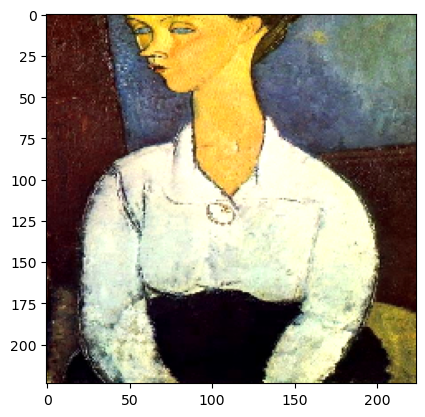

In [15]:
import matplotlib.pyplot as plt
img_mean=(0.485, 0.456, 0.406)
img_std= (0.229,0.224,0.224)
t,l = next(iter(train_loader))
print(t.shape,l[0])
print(torch.max(t[0]), torch.min(t[0]))
t[0]= t[0] * torch.tensor(img_std).view(3, 1, 1) + torch.tensor(img_mean).view(3, 1, 1)
plt.imshow(t[0].detach().cpu().numpy().transpose(1,2,0))

In [16]:
from torchvision.models import convnext_large,ConvNeXt_Large_Weights
from torchvision import models

import timm
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(classes)):
        super(BaseModel, self).__init__()
        #self.backbone = convnext_large(weight=ConvNeXt_Large_Weights.DEFAULT)
        # self.backbone = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)
        self.backbone = models.convnext_small(weights=models.ConvNeXt_Small_Weights.IMAGENET1K_V1)
        
        #self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        self.drop = nn.Dropout(0.5,inplace=True)
    def forward(self, x):
        x = self.backbone(x)
        x = self.drop(x)
        x = self.classifier(x)
        return x

In [17]:
import torchsummary
model = BaseModel()
torchsummary.summary(model, (3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

CustomLoss
#pytorch 참고

In [18]:
def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
    classes=classes
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs (Tensor): A float tensor of arbitrary shape.
                The predictions for each example.
        targets (Tensor): A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha (float): Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default: ``0.25``.
        gamma (float): Exponent of the modulating factor (1 - p_t) to
                balance easy vs hard examples. Default: ``2``.
        reduction (string): ``'none'`` | ``'mean'`` | ``'sum'``
                ``'none'``: No reduction will be applied to the output.
                ``'mean'``: The output will be averaged.
                ``'sum'``: The output will be summed. Default: ``'none'``.
    Returns:
        Loss tensor with the reduction option applied.
    """
    # Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py
    p = torch.sigmoid(inputs)
    # label smoothing
    targets = targets*(1-0.1)+0.1/50
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)
    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss
    # 라벨마다 가중치
    for i in range(targets.shape[0]):
        k = targets[i].argmax(0).item()
        more = torch.tensor(classes[list(classes.keys())[k]][1])
        loss[i] = loss[i]*63/more
        
    # Check reduction option and return loss accordingly
    if reduction == "none":
        pass
    elif reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()
    else:
        raise ValueError(
            f"Invalid Value for arg 'reduction': '{reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
        )
    return loss

In [19]:

def train(model, optimizer, trian_loader, test_loader, scheduler, device):
    model.to(device)
    history = {'train_loss':[],'val_loss':[],'f1_score':[]}
    #criterion = nn.CrossEntropyLoss().to(device)
    criterion = sigmoid_focal_loss

    best_score = 0
    count = 0
    for epoch in range(1,CFG['EPOCHS']):
        model.train()
        train_loss = []
        for img , label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.to(device)
            optimizer.zero_grad()

            model_pred = model(img)

            loss = criterion(model_pred, label)

            loss.mean().backward()
            optimizer.step()

            train_loss.append(loss.mean().item())
            #print(loss.item())
            #break
        tr_loss  = np.mean(np.array(train_loss))

        val_loss, val_score = validation(model,criterion, test_loader, device)

        print(f'Epoch [{epoch}], Train Loss : {tr_loss:.5f}, Val Loss : {val_loss:.5f}, Val F1 Score : {val_score:.5f}')

        history['train_loss'].append(tr_loss)
        history['val_loss'].append(val_loss)
        history['f1_score'].append(val_score)

        if scheduler is not None:
            scheduler.step()
        if best_score < val_score:
            best_model = model
            best_score = val_score
            if val_score > 0.7:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                },f'./checkpoint/best_{val_score:.4f}.pth')
                print('Model Saved')
        else:
            if count >5:
                print('early stopping')
                break
            count +=1
    return history

In [20]:
def competition_metric(true,pred):
    return f1_score(true,pred,average='macro')

def validation(model, criterion,test_loader, device):
    model.eval()

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.to(device)

            model_pred = model(img)

            loss = criterion(model_pred, label)

            val_loss.append(loss.mean().item())
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.argmax(1).detach().cpu().numpy().tolist()
    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

In [21]:
optimizer = torch.optim.Adam(params=model.parameters(), lr = 5e-5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=1,T_mult=2,eta_min=5e-7)
scheduler = None

history = train(model, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 74/74 [00:16<00:00,  4.45it/s]


Epoch [1], Train Loss : 0.00843, Val Loss : 0.00469, Val F1 Score : 0.07463


100%|██████████| 74/74 [00:16<00:00,  4.41it/s]


Epoch [2], Train Loss : 0.00488, Val Loss : 0.00405, Val F1 Score : 0.17589


100%|██████████| 74/74 [00:16<00:00,  4.42it/s]


Epoch [3], Train Loss : 0.00420, Val Loss : 0.00330, Val F1 Score : 0.37129


100%|██████████| 74/74 [00:16<00:00,  4.46it/s]


Epoch [4], Train Loss : 0.00353, Val Loss : 0.00282, Val F1 Score : 0.48909


100%|██████████| 74/74 [00:16<00:00,  4.44it/s]


Epoch [5], Train Loss : 0.00303, Val Loss : 0.00247, Val F1 Score : 0.56347


100%|██████████| 74/74 [00:16<00:00,  4.40it/s]


Epoch [6], Train Loss : 0.00261, Val Loss : 0.00237, Val F1 Score : 0.58318


100%|██████████| 74/74 [00:16<00:00,  4.45it/s]


Epoch [7], Train Loss : 0.00226, Val Loss : 0.00224, Val F1 Score : 0.61932


100%|██████████| 74/74 [00:16<00:00,  4.42it/s]


Epoch [8], Train Loss : 0.00201, Val Loss : 0.00212, Val F1 Score : 0.63808


100%|██████████| 74/74 [00:16<00:00,  4.38it/s]


Epoch [9], Train Loss : 0.00181, Val Loss : 0.00196, Val F1 Score : 0.66342


100%|██████████| 74/74 [00:16<00:00,  4.49it/s]


Epoch [10], Train Loss : 0.00159, Val Loss : 0.00188, Val F1 Score : 0.68987


100%|██████████| 74/74 [00:16<00:00,  4.43it/s]


Epoch [11], Train Loss : 0.00138, Val Loss : 0.00186, Val F1 Score : 0.68353


100%|██████████| 74/74 [00:16<00:00,  4.42it/s]


Epoch [12], Train Loss : 0.00127, Val Loss : 0.00191, Val F1 Score : 0.71542
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.42it/s]


Epoch [13], Train Loss : 0.00110, Val Loss : 0.00201, Val F1 Score : 0.70330


100%|██████████| 74/74 [00:16<00:00,  4.50it/s]


Epoch [14], Train Loss : 0.00101, Val Loss : 0.00184, Val F1 Score : 0.71525


100%|██████████| 74/74 [00:16<00:00,  4.52it/s]


Epoch [15], Train Loss : 0.00091, Val Loss : 0.00193, Val F1 Score : 0.73869
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.48it/s]


Epoch [16], Train Loss : 0.00081, Val Loss : 0.00171, Val F1 Score : 0.74223
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.46it/s]


Epoch [17], Train Loss : 0.00071, Val Loss : 0.00194, Val F1 Score : 0.74344
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.44it/s]


Epoch [18], Train Loss : 0.00066, Val Loss : 0.00185, Val F1 Score : 0.75363
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.49it/s]


Epoch [19], Train Loss : 0.00064, Val Loss : 0.00188, Val F1 Score : 0.77382
Model Saved


100%|██████████| 74/74 [00:16<00:00,  4.38it/s]


Epoch [20], Train Loss : 0.00056, Val Loss : 0.00206, Val F1 Score : 0.75964


100%|██████████| 74/74 [00:16<00:00,  4.38it/s]


Epoch [21], Train Loss : 0.00058, Val Loss : 0.00223, Val F1 Score : 0.76655


100%|██████████| 74/74 [00:16<00:00,  4.41it/s]


Epoch [22], Train Loss : 0.00046, Val Loss : 0.00206, Val F1 Score : 0.76091


 10%|▉         | 29/296 [00:17<02:38,  1.68it/s]

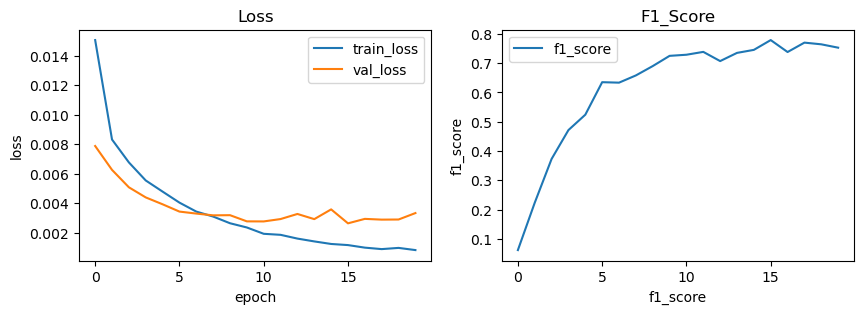

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(range(len(history['train_loss'])),history['train_loss'], label='train_loss')
plt.plot(range(len(history['train_loss'])),history['val_loss'], label='val_loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(history['f1_score'])), history['f1_score'], label='f1_score')
plt.title('F1_Score')
plt.ylabel('f1_score')
plt.xlabel('f1_score')
plt.legend()

plt.show()